In [1]:
FOLDER_ROOT = 'F:\Github'

In [3]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import sys
sys.path.append(FOLDER_ROOT)

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, f1_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from joblib import Parallel, delayed

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from os import cpu_count

from river import stats
from river import synth
from river import stream

In [5]:
size=20000
primary_stream = synth.AnomalySine(n_samples=size,
                                   n_anomalies=250, #default
                                   contextual=True,
                                   n_contextual=250, #default
                                   shift=4, #default
                                   noise=0.5, #default
                                   replace=True, #default
                                   seed=100
)
second_stream = synth.AnomalySine(n_samples=size,
                                  n_anomalies=470,
                                  contextual=True,
                                  n_contextual=250, #default
                                  shift=9,
                                  noise=0.8,
                                  replace=True, #default
                                  seed=200
)

df_stream = synth.ConceptDriftStream(stream=primary_stream,
                                     drift_stream=second_stream,
                                     position=2000,
                                     width=1000,
                                     seed=300,
                                     alpha=None #default
)

all_stream = [np.append(list(X.values()), 
                        y) for X, y in df_stream.take(size)]

df_stream = pd.DataFrame(all_stream, columns=['sine', 'cosine', 'target'])

In [6]:
#df_stream = pd.read_csv('https://drive.google.com/u/0/uc?id=1XfWljItYj1oreR1azMlSIip0LIohRvRs&export=download',
#                        engine='c', low_memory=True, memory_map=True)

X = df_stream[df_stream.columns[:-1]]
y = df_stream['target']
#https://drive.google.com/file/d/1XfWljItYj1oreR1azMlSIip0LIohRvRs/view?usp=sharing

In [10]:
X.shape

(20000, 2)

In [11]:
df_stream.head()

,sine,cosine,target
0,-0.874883,1.756533,0.0
1,0.418744,1.317549,0.0
2,1.055943,0.016559,0.0
3,0.555421,0.490936,0.0
4,1.332131,0.952837,0.0


In [12]:
print('List columns:')
print(list(df_stream.columns))
print('Labels:')
print(set(y))

List columns:
['sine', 'cosine', 'target']
Labels:
{0.0, 1.0}


In [7]:
X = df_stream[df_stream.columns[:-1]]
y = df_stream['target']

X_train = X[:1200].values
y_train = y[:1200].values
X_test = X[12000:].values
y_test = y[12000:].values

y_train = y_train.astype(int)
y_test = y_test.astype(int)

x_columns = X.columns

In [16]:
entro = stats.Entropy(alpha=1)
print("X_train\n", X_train[0])
print('Entro: ', entro.get())
xi = {x_columns[0]: X_train[0][0]}
print('Xi: ', xi)
entro.update(X_train[0][0])
print('Entro: ', entro.get())

print('Entro: ', entro.update(X_train[0][0]).get())
print('Entro: ', entro.update(X_train[1][0]).get())
print('Entro: ', entro.update(X_train[2][0]).get())



X_train
 [-0.87488274  1.75653304]
Entro:  0
Xi:  {'sine': -0.8748827365273487}
Entro:  0.0
Entro:  0.0
Entro:  0.6365141012487197
Entro:  1.0397206708484008


In [28]:
clf_rf = RandomForestClassifier(n_estimators=100,
                                criterion='entropy',
                                max_features='auto',
                                bootstrap=True,
                                oob_score=True,
                                random_state=42,
                                warm_start=True,
                                n_jobs=-1
)
clf_rf = clf_rf.fit(X_train, y_train)
print("\nRandom Forest (with 100 trees) trained.")
print('Score within of training data = ', clf_rf.score(X_train, y_train))


Random Forest (with 100 trees) trained.
Score within of training data =  1.0


In [29]:
y_pred = clf_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('Y pred shape: ', y_pred.shape)
print('Acc natural: ', acc)

Y pred shape:  (8000,)
Acc natural:  0.969375


In [30]:
dt0 = clf_rf.estimators_[0]

In [31]:
y_pred = dt0.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print('Y pred shape: ', y_pred.shape)
print('Acc natural: ', acc)

Y pred shape:  (8000,)
Acc natural:  0.957375


In [8]:
# calcula o vetor de entropia para o atributo 1
entropy_sine = np.array([entro.update(Xi[0]).get() for Xi in X_test])
# calcula o vetor de entropia para o atributo 2
entropy_cosine = np.array([entro.update(Xi[1]).get() for Xi in X_test])

print("Entropy Sine Shape: ", entropy_sine.shape)
print("Entropy Cosine Shape: ", entropy_cosine.shape)

entropy_sum = entropy_sine + entropy_cosine
entropy_min = entropy_sine - entropy_cosine

print('Entropy Sum Attr: ', entropy_sum.shape)

score = dt0.score(X_test, y_test, sample_weight=entropy_sum)
score1 = dt0.score(X_test, y_test, sample_weight=entropy_sine)
score2 = dt0.score(X_test, y_test, sample_weight=entropy_cosine)
score3 = dt0.score(X_test, y_test, sample_weight=entropy_min)

print('Score: ', score)
print('Score 1: ', score1)
print('Score 2: ', score2)
print('Score 3: ', score3)

fi = dt0.feature_importances_
print('Feature Importance: ', fi)

entropy_pond = (entropy_sine * fi[0]) + (entropy_cosine * fi[1])

score4 = dt0.score(X_test, y_test, sample_weight=entropy_pond)
print('Score 4: ', score4)

fator = 1 / np.sum(entropy_pond)
entropy_reg = entropy_pond * fator

score5 = dt0.score(X_test, y_test, sample_weight=entropy_reg)
print('Score 5: ', score5)

fator = 1 / np.sum(entropy_sine)
entropy_sine_f = entropy_sine * fator

fator = 1 / np.sum(entropy_cosine)
entropy_cosine_f = entropy_cosine * fator

entropy_sum_f = entropy_sine_f + entropy_cosine_f

score6 = dt0.score(X_test, y_test, sample_weight=entropy_sum_f)
print('Score 6: ', score6)

entropy_pond_f = (entropy_sine_f * fi[0]) + (entropy_cosine_f * fi[1])

score7 = dt0.score(X_test, y_test, sample_weight=entropy_pond_f)
print('Score 7: ', score7)

entropy_pond_f2 = ((1-entropy_sine_f) * fi[0]) + ((1-entropy_cosine_f) * fi[1])
score8 = dt0.score(X_test, y_test, sample_weight=entropy_pond_f2)
print('Score 8: ', score8)

NameError: name 'entro' is not defined

In [69]:
#from sklearn.preprocessing import normalize

print('Shape entropy sine: ', entropy_sine.shape)
print('Shape entropy cosine: ', entropy_cosine.shape)

#entropy_sine_norm = Normalizer(norm='l1').fit_transform(entropy_sine)
#entropy_cosine_norm = Normalizer(norm='l1').fit_transform(entropy_cosine)

# usando z score (Xi - media) / desvio padrão
mean_entropy_sine = np.mean(entropy_sine)
std_entropy_sine = np.std(entropy_sine)
entropy_sine_norm = (entropy_sine - mean_entropy_sine) / std_entropy_sine

mean_entropy_cosine = np.mean(entropy_cosine)
std_entropy_cosine = np.std(entropy_cosine)
entropy_cosine_norm = (entropy_cosine - mean_entropy_cosine) / std_entropy_cosine

fi = dt0.feature_importances_ 
print('Feature importance: ', list(fi))

entropy_pond_norm = ((1-entropy_sine_norm) * fi[0]) + ((1-entropy_cosine_norm) * fi[1])
score9 = dt0.score(X_test, y_test, sample_weight=entropy_pond_norm)

print('Score 9:', score9)

Shape entropy sine:  (8000,)
Shape entropy cosine:  (8000,)
Feature importance:  [0.264655185303923, 0.7353448146960769]
Score 9: 0.9576044919124431


In [72]:
print('Shape entropy sine: ', entropy_sine.shape)
print('Shape entropy cosine: ', entropy_cosine.shape)

# usando minx-max (Xi - xmin) / (xmax - xmin)
max_entropy_sine = np.max(entropy_sine)
min_entropy_sine = np.min(entropy_sine)
entropy_sine_minmax = (entropy_sine - min_entropy_sine) / (max_entropy_sine - min_entropy_sine)

max_entropy_cosine = np.max(entropy_cosine)
min_entropy_cosine = np.min(entropy_cosine)
entropy_cosine_minmax = (entropy_cosine - min_entropy_cosine) / (max_entropy_cosine - min_entropy_cosine)

fi = dt0.feature_importances_ 
print('Feature importance: ', list(fi))

entropy_pond_minmax = ((1-entropy_sine_minmax) * fi[0]) + ((1-entropy_cosine_minmax) * fi[1])
score10 = dt0.score(X_test, y_test, sample_weight=entropy_pond_minmax)

print('Score 10:', score10)

Shape entropy sine:  (8000,)
Shape entropy cosine:  (8000,)
Feature importance:  [0.264655185303923, 0.7353448146960769]
Score 10: 0.9575043921251362


In [73]:
print('Proporcional')
print('Sine 0: ', entropy_sine_f[0])
print('Cosine 0: ', entropy_cosine_f[0])

print('')

print('Normalizado Z-Score')
print('Sine 0: ', entropy_sine_norm[0])
print('Cosine 0: ', entropy_cosine_norm[0])

print('')

print('Normalizado Min-Max')
print('Sine 0: ', entropy_sine_minmax[0])
print('Cosine 0: ', entropy_cosine_minmax[0])

Proporcional
Sine 0:  0.00012504718147916748
Cosine 0:  0.00012504029010748497

Normalizado Z-Score
Sine 0:  1.7723197826391262
Cosine 0:  1.7740830137145667

Normalizado Min-Max
Sine 0:  1.0
Cosine 0:  1.0


In [47]:
print('Antes: ', entropy_pond[0])
print('Depois: ', ((1 / np.sum(entropy_pond)) * entropy_pond[0]))

Antes:  10.204988383702862
Depois:  0.00012509220743098598


In [46]:
entropy_reg[0]

0.00012509220743098598

In [50]:
entropy_pond_f[0]

0.00012507364885243832

In [9]:
entropy_sine = [entro.update(Xi[0]).get() for Xi in X.values]
print(len(entropy_sine))

10000


In [10]:
entropy_cosine = [entro.update(Xi[1]).get() for Xi in X.values]
print(len(entropy_cosine))

10000


In [11]:
entropy_target = [entro.update(Xi).get() for Xi in y]
print(len(entropy_target))

10000


In [12]:
entropy_attrsum = np.array(entropy_sine) + np.array(entropy_cosine)
entropy_allsum = np.array(entropy_sine) + np.array(entropy_cosine) + np.array(entropy_target)

In [13]:
n_class = np.unique(y).astype(int)
probabilitys = {}
for i in n_class:
    probabilitys[i] = []
    probabilitys= [[((y[:(i+1)] == ni_class).sum()/(i+1)) for i in range(y.shape[0])] for ni_class in n_class]

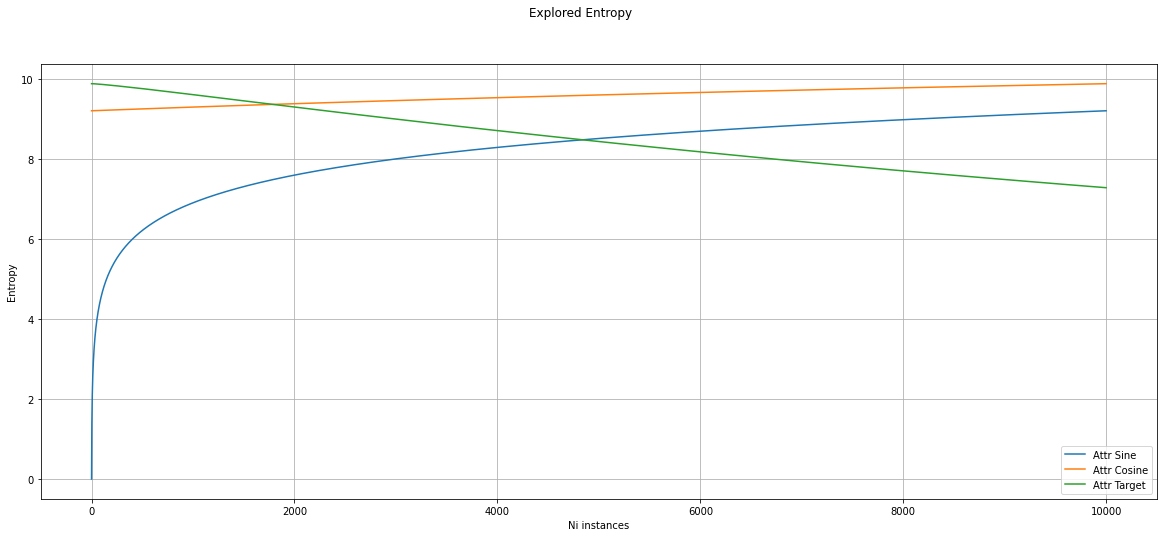

In [16]:
fig, axs = plt.subplots(figsize=(20,8))

fig.suptitle('Explored Entropy')

axs.plot(range(len(entropy_sine)), entropy_sine, label='Attr Sine')

axs.plot(range(len(entropy_cosine)), entropy_cosine, label='Attr Cosine')

axs.plot(range(len(entropy_target)), entropy_target, label='Attr Target')

axs.set(xlabel='Ni instances', ylabel='Entropy')
#axs[0].set(ylim=(0.0, 1.0))
axs.grid()
axs.legend()
plt.show();

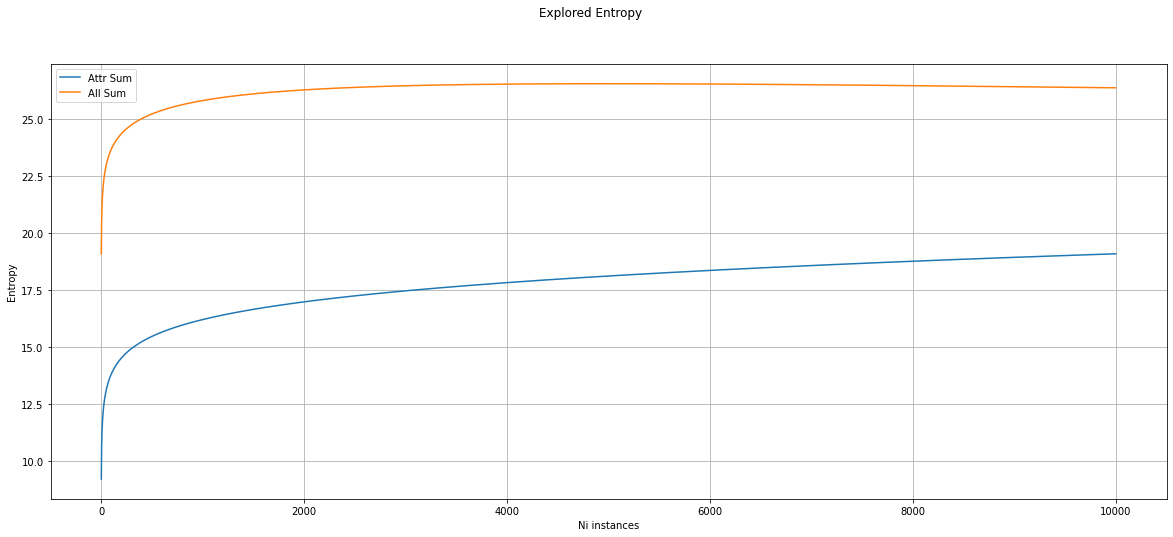

In [17]:
fig, axs = plt.subplots(figsize=(20,8))

fig.suptitle('Explored Entropy')

axs.plot(range(entropy_attrsum.shape[0]), entropy_attrsum, label='Attr Sum')

axs.plot(range(entropy_allsum.shape[0]), entropy_allsum, label='All Sum')

axs.set(xlabel='Ni instances', ylabel='Entropy')
#axs[0].set(ylim=(0.0, 1.0))
axs.grid()
axs.legend()
plt.show();

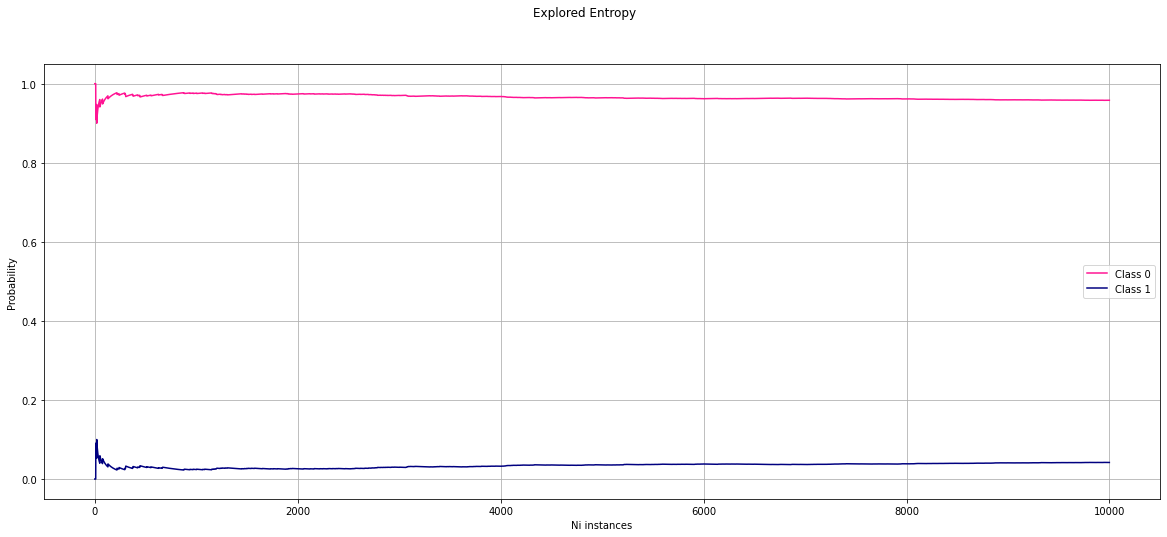

In [18]:
fig, axs = plt.subplots(figsize=(20,8))

fig.suptitle('Explored Entropy')

axs.plot(range(len(probabilitys[0])), probabilitys[0], color='#FF1493', label='Class 0')

axs.plot(range(len(probabilitys[1])), probabilitys[1], color='#000080', label='Class 1')

axs.set(xlabel='Ni instances', ylabel='Probability')
axs.grid()
axs.legend()

plt.show();

array([0., 1., 2., 3., 4.])

In [4]:
vetor = [2,5,8,9,11,15,16,18]
print('Media n=5: ', np.mean(vetor[:5]))
print('Media n=6: ', np.mean(vetor[:6]))
print('Media n=7: ', np.mean(vetor[:7]))
print('Media n=8: ', np.mean(vetor[:8]))
print('')
print('Desvio padrão n=5: ', np.std(vetor[:5]))
print('Desvio padrão n=6: ', np.std(vetor[:6]))
print('Desvio padrão n=7: ', np.std(vetor[:7]))
print('Desvio padrão n=8: ', np.std(vetor[:8]))

Media n=5:  7.0
Media n=6:  8.333333333333334
Media n=7:  9.428571428571429
Media n=8:  10.5

Desvio padrão n=5:  3.1622776601683795
Desvio padrão n=6:  4.149966532662911
Desvio padrão n=7:  4.686062704816207
Desvio padrão n=8:  5.220153254455275


In [41]:
df = {'a': [1,2,3,4,5],'B': [6,7,8,9,10]}
za = (df['a'] - np.mean(df['a'])) / np.std(df['a'])
print('Z-score a: ', list(za))
zB = (df['B'] - np.mean(df['B'])) / np.std(df['B'])
print('Z-score B: ', list(zB))

Z-score a:  [nan, 1.0, 1.224744871391589, 1.3416407864998738, 1.414213562373095]
Z-score B:  [-1.414213562373095, -0.7071067811865475, 0.0, 0.7071067811865475, 1.414213562373095]


C:\Users\Danilo Santos\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [30]:
df = [{'a': 1, 'B': 6},
      {'a': 2, 'B': 7},
      {'a': 3, 'B': 8},
      {'a': 4, 'B': 9},
      {'a': 5, 'B': 10}]

In [34]:
from midas.v3.normalizer import OnlineNormalizer

myNorm = OnlineNormalizer()
_ = [myNorm.learn_one(Xi) for Xi in df]

3.0


In [6]:
from midas.v3.stats import OnlineStats
sos = OnlineStats()
for Xi in vetor:
    print(sos.update(Xi).get('mean'))
    
sos = OnlineStats() #**{'ddof': 0, "n_observations": 1, 'mean': 1}
for Xi in vetor:
    print(sos.update(Xi).get('std'))

del sos

2.0
3.5
5.0
6.0
7.0
8.333333333333334
9.428571428571429
10.5
0.0
1.5
2.449489742783178
2.7386127875258306
3.1622776601683795
4.14996653266291
4.686062704816207
5.2201532544552744


In [86]:
print('Len: ', len(vetor[:5]))
print('Vetor: ', vetor[:5])
# calcula a media -> mean(X)
m5 = np.mean(vetor[:5])
print('m5: ', m5)
# subtrai a média de cada elemento do vetor -> Xi - mean(X)
ma = vetor[:5] - m5
print('ma: ', ma)
# Eleva o quadro o resultado anterior -> (Xi-mean(X))^2 
mp = np.power(ma, 2)
print('mp: ', mp)
# Soma o vetor inteiro -> sum((Xi-mean(X))^2)
ms = np.sum(mp)
print('ms: ', ms)
# Divide pelo tamanho do vetor -> sum((Xi-mean(X))^2) / n
mn = ms / 5
print('mn: ', mn)
# Calcula a raiz quadrada -> sqrt(sum((Xi-mean(X))^2) / n)
mr = np.sqrt(mn)
print('mr: ', mr)

Len:  5
Vetor:  [2, 5, 8, 9, 11]
m5:  7.0
ma:  [-5. -2.  1.  2.  4.]
mp:  [25.  4.  1.  4. 16.]
ms:  50.0
mn:  10.0
mr:  3.1622776601683795


In [87]:
np.sqrt(np.sum(np.power((vetor[:5]-np.mean(vetor[:5])),2)/len(vetor[:5])))

3.1622776601683795

In [91]:
3.16 - np.sqrt(np.power((15-np.mean(vetor[:6])),2)/6)

0.4383447302409138

In [92]:
3.1622776601683795 + 0.4383447302409138

3.6006223904092933

In [101]:
class OnlineVariance(object):
    """
    Welford's algorithm computes the sample variance incrementally.
    """

    def __init__(self, iterable=None, ddof=1):
        self.ddof, self.n, self.mean, self.M2 = ddof, 0, 0.0, 0.0
        if iterable is not None:
            for datum in iterable:
                self.include(datum)

    def include(self, datum):
        self.n += 1
        self.delta = datum - self.mean
        self.mean += self.delta / self.n
        self.M2 += self.delta * (datum - self.mean)

    @property
    def variance(self):
        return self.M2 / (self.n - self.ddof)

    @property
    def std(self):
        return np.sqrt(self.variance)

In [5]:
sor = OnlineVariance(ddof=0)
for Xi in vetor:
    sor.include(Xi)
    print('Std: ', sor.std)

NameError: name 'OnlineVariance' is not defined

In [111]:
from collections.abc import Iterable

e = 10
if isinstance(e, Iterable):
    print('é 10')
    
e = [1,2]
if isinstance(e, Iterable):
    print('é list')
    
e = np.array([4,5.6,7])
if isinstance(e, Iterable):
    print('é np')

é list
é np


In [98]:
cont = 0
def count(xi):
    global cont
    cont += xi

[count(j) for j in [1,2,3,4,5]]

print(cont)

15


In [9]:
type(1.0) is int

False

In [10]:
a = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
print(a.items())

dict_items([('a', 1), ('b', 2), ('c', 3), ('d', 4)])


In [9]:
b = {}
b['at1'] = 1
display(b)
print(b.keys())

{'at1': 1}

dict_keys(['at1'])


In [10]:
isinstance(b, dict)

True

In [11]:
dict(zip(['a','b','c'], [1,2,3]))

{'a': 1, 'b': 2, 'c': 3}

In [12]:
c = [1,2,3,4]
c.append(5)
print(c)

[1, 2, 3, 4, 5]


In [45]:
dt = {'a': [1,2,3,4,5], 'b': [6,7,8,9,10]}

In [46]:
dt

{'a': [1, 2, 3, 4, 5], 'b': [6, 7, 8, 9, 10]}

In [47]:
type(dt)

dict

In [104]:
tmp = {}
for k in dt.keys():
    tmp[k] = [{k: v} for v in dt[k]]
print(tmp)

{'a': [{'a': 1}, {'a': 2}, {'a': 3}, {'a': 4}, {'a': 5}], 'b': [{'b': 6}, {'b': 7}, {'b': 8}, {'b': 9}, {'b': 10}]}


In [89]:
l, c = len(list(tmp.values())), len(list(tmp.values())[0])
print(l, c)

tpm = []
values = list(tmp.values())
for i in range(c):
    tpm.append([values[j][i] for j in range(l)])

2 5


In [90]:
tpm

[[{'a': 1}, {'b': 6}],
 [{'a': 2}, {'b': 7}],
 [{'a': 3}, {'b': 8}],
 [{'a': 4}, {'b': 9}],
 [{'a': 5}, {'b': 10}]]

In [102]:
tpx = []
for x in tpm:
    tpd = {}
    for d in x:
        k = list(d.keys())[0]
        v = list(d.values())[0]
        tpd[k] = v
    tpx.append(tpd)

print(tpx)

[{'a': 1, 'b': 6}, {'a': 2, 'b': 7}, {'a': 3, 'b': 8}, {'a': 4, 'b': 9}, {'a': 5, 'b': 10}]


In [113]:
print(len(dt.keys()))
print(len(list(dt.values())[0]))

2
5


In [124]:
# 1ª Otimização
tmp = {}
#for k in dt.keys():
#    tmp[k] = [{k: v} for v in dt[k]]
l, c = len(dt.keys()), len(list(dt.values())[0])
tmp = [[{k: v} for v in dt[k]] for k in dt.keys()]
print(tmp)

print(tmp[0][0])
print(tmp[1][0])

#tpx = []
#for ic in range(c):
#    tpd = {}
#    for il in range(l):
#        k = list(tmp[il][ic].keys())[0]
#        v = list(tmp[il][ic].values())[0]
#        tpd[k] = v
#    tpx.append(tpd)

tpx = [{list(tmp[il][ic].keys())[0]:list(tmp[il][ic].values())[0] for il in range(l)} for ic in range(c)]
print(tpx)

#tpx = []
#for x in tmp:
#    tpd = {}
#    for d in x:
#        k = list(d.keys())[0]
#        v = list(d.values())[0]
#        tpd[k] = v
#    tpx.append(tpd)

#print(tpx)

[[{'a': 1}, {'a': 2}, {'a': 3}, {'a': 4}, {'a': 5}], [{'b': 6}, {'b': 7}, {'b': 8}, {'b': 9}, {'b': 10}]]
{'a': 1}
{'b': 6}
[{'a': 1, 'b': 6}, {'a': 2, 'b': 7}, {'a': 3, 'b': 8}, {'a': 4, 'b': 9}, {'a': 5, 'b': 10}]


In [ ]:
# 2ª Otimização
tmp = {}
l, c = len(dt.keys()), len(list(dt.values())[0])
tmp = [[{k: v} for v in dt[k]] for k in dt.keys()]
print(tmp)

print(tmp[0][0])
print(tmp[1][0])

tpx = [{list(tmp[il][ic].keys())[0]:list(tmp[il][ic].values())[0] for il in range(l)} for ic in range(c)]
print(tpx)


[('a', 1), ('a', 2), ('a', 3), ('a', 4), ('a', 5)]

In [123]:
lot = {str(i):i*2 for i in range(5)}
print(lot)

{'0': 0, '1': 2, '2': 4, '3': 6, '4': 8}


In [86]:
list(tmp.values())

[[{'a': 1}, {'a': 2}, {'a': 3}, {'a': 4}, {'a': 5}],
 [{'b': 6}, {'b': 7}, {'b': 8}, {'b': 9}, {'b': 10}]]

In [88]:
list(tmp.values())[0][0]

{'a': 1}

In [49]:
help(dict)

Help on class dict in module builtins:

class dict(object)
 |  dict() -> new empty dictionary
 |  dict(mapping) -> new dictionary initialized from a mapping object's
 |      (key, value) pairs
 |  dict(iterable) -> new dictionary initialized as if via:
 |      d = {}
 |      for k, v in iterable:
 |          d[k] = v
 |  dict(**kwargs) -> new dictionary initialized with the name=value pairs
 |      in the keyword argument list.  For example:  dict(one=1, two=2)
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, key, /)
 |      True if the dictionary has the specified key, else False.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __init__(self,

In [366]:
river_entropy = stats.Entropy(alpha=1)
vetor_test = [1,1,2,2,3,3,4,4]

for vt in vetor_test:
    ent = river_entropy.update(vt).get()
    norm = ent / np.log(len(vetor_test))
    print('Entro: ', ent, 'Norm: ', norm)

Entro:  0.0 Norm:  0.0
Entro:  0.0 Norm:  0.0
Entro:  0.6365141012487197 Norm:  0.3060985791091412
Entro:  0.69314712912013 Norm:  0.3333333085960112
Entro:  1.054920086606636 Norm:  0.5073093258271832
Entro:  1.0986122199276567 Norm:  0.5283208005165485
Entro:  1.3517839066352175 Norm:  0.650070646152046
Entro:  1.3862942836796082 Norm:  0.6666666294257629


In [365]:
# H(X) = sum(p(xi)*log2(1/p(xi)))
# p(xi)
#vetor_test2 = [1,1,2,1,2,1,2,3,4,5,1,1,1,1,5,5,5,5]
vetor_test = [1,1,2,2,3,3,4,4]
eps=1e-8
unique, counts = np.unique(vetor_test, return_counts=True)
print('Unique: ', unique)
print('Counts: ', counts)

sum_occurence = sum(counts)
print('Sum occurence: ',sum_occurence)

probabilitys = [SOi/sum_occurence for SOi in counts]
print('Probabilitys: ', probabilitys)
print('Check: ', sum(probabilitys))

#erro = 1 - sum(probabilitys)
#print('Erro: ', erro)

#if erro > 0:
#    probabilitys.append(erro)
#print('Prob+erro: ', probabilitys)

hX = [proba * np.log(1/proba) for proba in probabilitys]
print('hX: ', hX)

HX = sum(hX)

print('HX: ', HX)

Hxn = HX / np.log(len(vetor_test))
print('Hxn: ', Hxn)

#Hxnee = (HX * np.log(2)) / np.log(len(vetor_test2))
#print('Hxnee: ', Hxnee)
# 1.21538
# 1.1699 -1
# 1.2293 -2
# 1.2868 -3
# 1.2868 -4
# 1.2868 -5

# HX:  1.908535281643568
# HX:  1.90853528164356

Unique:  [1 2 3 4]
Counts:  [2 2 2 2]
Sum occurence:  8
Probabilitys:  [0.25, 0.25, 0.25, 0.25]
Check:  1.0
hX:  [0.34657359027997264, 0.34657359027997264, 0.34657359027997264, 0.34657359027997264]
HX:  1.3862943611198906
Hxn:  0.6666666666666667


In [318]:
print(3/2)
ddof = 1
print((3-ddof)/(2-ddof))

1.5
2.0


In [293]:
import statistics
import math
from numpy import log as ln

vetor_test2 = [1,1,2,1,2,1,2,3,4,5,1,1,1,1,5]

unique, counts = np.unique(vetor_test2, return_counts=True)
print('Unique: ', unique)
print('Counts: ', counts)

sum_occurence = sum(counts)
print('Sum occurence: ',sum_occurence)

probabilitys = [SOi/sum_occurence for SOi in counts]
print('Probabilitys: ', probabilitys)
print('Check: ', sum(probabilitys))

variancia = statistics.variance(probabilitys)
print('Variancia: ', variancia)

H = math.log2((variancia * math.sqrt(2 * math.pi * math.e)))

print('H: ', H/2)

Unique:  [1 2 3 4 5]
Counts:  [8 3 1 1 2]
Sum occurence:  15
Probabilitys:  [0.5333333333333333, 0.2, 0.06666666666666667, 0.06666666666666667, 0.13333333333333333]
Check:  1.0
Variancia:  0.03777777777777778
H:  -1.3396113823930282


In [275]:
# H(X) = sum(p(xi)*log2(1/p(xi)))
# p(xi)
vetor_test2 = [1,1,2,1,2,1,2,3,4,5,1,1,1,1,5]
eps=1e-8
unique, counts = np.unique(vetor_test, return_counts=True)
print('Unique: ', unique)
print('Counts: ', counts)

sum_occurence = sum(counts)
print('Sum occurence: ',sum_occurence)

probabilitys = [SOi/sum_occurence for SOi in counts]
print('Probabilitys: ', probabilitys)
print('Check: ', sum(probabilitys))

#hX = [proba * np.log(1/proba) for proba in probabilitys]
#print('hX: ', hX)

#HX = (1/np.log(2)) * (sum(probabilitys) * sum([(((1 - proba)**i)/(i+1)) for i, proba in enumerate(probabilitys)]))
HX = (1/np.log(2)) * sum([(((1 - proba)**i)/(i+1)) for i, proba in enumerate(probabilitys)])
print('HX: ', HX)


Unique:  [1 2 3 4 5]
Counts:  [8 3 1 1 2]
Sum occurence:  15
Probabilitys:  [0.5333333333333333, 0.2, 0.06666666666666667, 0.06666666666666667, 0.13333333333333333]
Check:  1.0
HX:  2.8947145226150397


In [270]:
print(probabilitys)
[(((1 - proba)**i)/(i+1)) for i, proba in enumerate(probabilitys)]

[0.5333333333333333, 0.2, 0.06666666666666667, 0.06666666666666667, 0.13333333333333333]


[1.0, 0.4, 0.2903703703703704, 0.20325925925925928, 0.11283358024691359]

In [187]:
from collections import Counter

cont = Counter(vetor_test)
#cont.update(vetor_test)
print(dict(cont))
print(sum(cont.values()))
#dir(cont)

{1: 4, 2: 1, 3: 1, 4: 3, 5: 2, 6: 1, 7: 1, -8: 1}
14


In [195]:
cont = Counter([1,1,1,1,1])
for vt in vetor_test:
    cont.update([vt])
    print(dict(cont))

cont.subtract({1: 2, -8: 2})

del cont[-8]
print('-')
print(cont)

{1: 6}
{1: 6, 2: 1}
{1: 6, 2: 1, 3: 1}
{1: 7, 2: 1, 3: 1}
{1: 8, 2: 1, 3: 1}
{1: 8, 2: 1, 3: 1, 4: 1}
{1: 8, 2: 1, 3: 1, 4: 2}
{1: 8, 2: 1, 3: 1, 4: 3}
{1: 8, 2: 1, 3: 1, 4: 3, 5: 1}
{1: 8, 2: 1, 3: 1, 4: 3, 5: 2}
{1: 8, 2: 1, 3: 1, 4: 3, 5: 2, 6: 1}
{1: 8, 2: 1, 3: 1, 4: 3, 5: 2, 6: 1, 7: 1}
{1: 9, 2: 1, 3: 1, 4: 3, 5: 2, 6: 1, 7: 1}
{1: 9, 2: 1, 3: 1, 4: 3, 5: 2, 6: 1, 7: 1, -8: 1}
-
Counter({1: 7, 4: 3, 5: 2, 2: 1, 3: 1, 6: 1, 7: 1})


In [198]:
ddof = {'a': [], 'b': 1, 'c': 'cs'}
ddof['a'].append([1,2,3,4])

In [199]:
ddof

{'a': [[1, 2, 3, 4]], 'b': 1, 'c': 'cs'}

In [208]:
ddof = Counter({'a': 1, 'b': 2, 'c': 3})
print(dict(ddof))

{'a': 1, 'b': 2, 'c': 3}


In [209]:
ddof = [2,5,7,1,3,6,8]
print(ddof)
dof = ddof.pop(0)
print(dof)
print(ddof)

[2, 5, 7, 1, 3, 6, 8]
2
[5, 7, 1, 3, 6, 8]


In [210]:
from joblib import Parallel, delayed

from collections import Counter

In [222]:
def _util_counters_subtract(counters, value):
    """
    Utiful function.

    Subtract value dict in list of counters.
    """
    _ = Parallel(n_jobs=-1,
                 verbose=0, require='sharedmem')(
        delayed(lambda c, v: c.subtract(v))(ci, value)
        for ci in counters
    )

def _parallel_del_counter_negative(counter, key):
    """
    Delete key with negative value from counter.

    This function is utility called from parallel execution.
    """
    if counter[key] <= 0:
        del counter[key]

def _util_del_counter_negative(counter):
    """
    Del key from counter with negative value.

    Delete the index negative from counter.
    """
    _ = Parallel(n_jobs=-1,
                 verbose=0, require='sharedmem')(
        delayed(_parallel_del_counter_negative)(counter, ck)
        for ck in counter
    )

def _util_del_counters_negative(counters):
    """
    Del counters index negative.

    Delete the index negative from counter within counters
    """
    _ = Parallel(n_jobs=-1,
                 verbose=0, require='sharedmem')(
        delayed(_util_del_counter_negative)(ci)
        for ci in counters
    )

In [220]:
list_conters = [
    Counter({'a': 1, 'b': 2, 'c': 3}),
    Counter({'d': 4, 'e': 5,  'f': 6}),
    Counter({'c': 1, 'd': 2, 'f': 3})
]

_util_counters_subtract(list_conters, {'a': 1, 'z': 5, 'f': 3})

for l in list_conters:
    print(dict(l))

{'a': 0, 'b': 2, 'c': 3, 'z': -5, 'f': -3}
{'d': 4, 'e': 5, 'f': 3, 'a': -1, 'z': -5}
{'c': 1, 'd': 2, 'f': 0, 'a': -1, 'z': -5}


In [223]:
_util_del_counters_negative(list_conters)

for l in list_conters:
    print(dict(l))

{'b': 2, 'c': 3}
{'d': 4, 'e': 5, 'f': 3}
{'c': 1, 'd': 2}


In [227]:
'c' in list_conters[0]

True

In [230]:
list_conters[0].keys()

dict_keys(['b', 'c'])

In [231]:
value = {'a': 1, 'z': 5, 'f': 3}
value.keys()

dict_keys(['a', 'z', 'f'])

In [250]:
list_conters = [
    Counter({'a': 1, 'b': 2, 'c': 3}),
    Counter({'d': 4, 'e': 5,  'f': 6}),
    Counter({'c': 1, 'd': 2, 'f': 3})
]

value = {'a': 3, 'z': 5, 'f': 3}

l = list_conters[1]
exs = {key:value[key] for key in value.keys() if key in l.keys()}

print(exs)

exy = Parallel(n_jobs=-1,
               verbose=0, require='sharedmem')(
            delayed(lambda k, v: k, v[k])(key, value)
            for key in value.keys() if key in l.keys()
)

print(exy)

{'f': 3}


TypeError: 'int' object is not subscriptable

In [244]:
{x:x+1 for x in range(4)}

{0: 1, 1: 2, 2: 3, 3: 4}

In [257]:
av = [1,2,3,45,67,8,9,1,12]
av[-1]

12

In [261]:
ddof = Counter({'a': 1, 'b': 2, 'c': 3})
ddof

Counter({'a': 1, 'b': 2, 'c': 3})

In [262]:
list(ddof)

['a', 'b', 'c']

In [363]:
size_attr = 12
n_partitions = 4
attr_a_floats = np.random.uniform(0.5, 3.0, size=(1, size_attr))[0]
# linspace -> Retorna números com espaçamento uniforme em um intervalo especificado
n_bins = np.linspace(np.amin(attr_a_floats), np.amax(attr_a_floats), n_partitions, dtype=np.float64)
# digitize -> Retorna os índices dos compartimentos aos quais cada valor na matriz de entrada pertence.
discretized_attr_a_floats = np.digitize(attr_a_floats, n_bins)

print('N bins: ', n_bins)
for a, d in zip(attr_a_floats, discretized_attr_a_floats):
    print('Attr value: ', a, " \tDiscretized: ", d)

N bins:  [0.51143542 1.32465918 2.13788293 2.95110668]
Attr value:  2.419490061591645  	Discretized:  3
Attr value:  0.5114354236377701  	Discretized:  1
Attr value:  0.7974285461997217  	Discretized:  1
Attr value:  2.7067111004255997  	Discretized:  3
Attr value:  1.1326619774019158  	Discretized:  1
Attr value:  1.4759456004483604  	Discretized:  2
Attr value:  1.3692895089661914  	Discretized:  2
Attr value:  2.234159070749879  	Discretized:  3
Attr value:  2.201222581311886  	Discretized:  3
Attr value:  2.951106684404706  	Discretized:  4
Attr value:  2.7675886761072532  	Discretized:  3
Attr value:  1.761250225325651  	Discretized:  2


array([[1.42087548, 2.25681438, 0.76785654, 0.80108725, 2.937309  ,
        2.15582132, 2.77335378, 0.95133128, 2.02170489, 1.53326068]])

In [ ]:
round(random.uniform(1,2), N)

In [367]:
hlp({})

NameError: name 'hlp' is not defined